In [1]:
import os
import sys

from IPython.core.pylabtools import figsize

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

print("PROJECT_ROOT =", PROJECT_ROOT)
print("Exists? ->", os.path.exists(PROJECT_ROOT))

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.load_data import load_creditcard_data

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline


plt.style.use("seaborn-v0_8")
sns.set_theme()


PROJECT_ROOT = /home/linux/PyCharmMiscProject/projects/adaptive-cost-sensitive-loss
Exists? -> True


In [2]:
X_train, y_train, X_test, y_test = load_creditcard_data(data_dir=os.path.join(PROJECT_ROOT, "data", "raw"))

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((227845, 30),
 (56962, 30),
 Class
 0    227451
 1       394
 Name: count, dtype: int64,
 Class
 0    56864
 1       98
 Name: count, dtype: int64)

In [3]:
# define a clean evaluation helper
# lets us evaluate any modell consistently

def evaluate_model(name, y_true, y_pred_labels, y_pred_probs):
    acc = accuracy_score(y_true, y_pred_labels)
    prec = precision_score(y_true, y_pred_labels, zero_division=0)
    rec = recall_score(y_true, y_pred_labels, zero_division=0)
    f1 = f1_score(y_true, y_pred_labels, zero_division=0)
    roc = roc_auc_score(y_true, y_pred_probs)
    pr_auc = average_precision_score(y_true, y_pred_probs)

    print(f"=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print(f"PR-AUC:    {pr_auc:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred_labels))
    print("\n")

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr_auc
    }


In [4]:
# baseline 1,  majority Class Model
majority_class = y_train.value_counts().idxmax()
print(f"majority class: {majority_class}")

# predict this class for every sample
y_pred_majority = np.full_like(y_test, majority_class)

# probabilties : always 0 for fraud and 1 for majority class
y_proba_majority = np.zeros_like(y_test, dtype=float)
y_proba_majority[majority_class == 1] = 1.0

results = []
results.append(
    evaluate_model("Majority Baseline", y_test, y_pred_majority, y_proba_majority)
)

majority class: 0
=== Majority Baseline ===
Accuracy:  0.9983
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.5000
PR-AUC:    0.0017

Confusion Matrix:
[[56864     0]
 [   98     0]]




In [5]:
# baseline 2 ,Logistic Regression
log_reg_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
])

log_reg_clf.fit(X_train, y_train)

y_proba_lr = log_reg_clf.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

results.append(
    evaluate_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
)

=== Logistic Regression ===
Accuracy:  0.9991
Precision: 0.8267
Recall:    0.6327
F1-score:  0.7168
ROC-AUC:   0.9605
PR-AUC:    0.7414

Confusion Matrix:
[[56851    13]
 [   36    62]]




In [6]:
# baseline 3,Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)
results.append(
    evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
)

=== Random Forest ===
Accuracy:  0.9996
Precision: 0.9419
Recall:    0.8265
F1-score:  0.8804
ROC-AUC:   0.9623
PR-AUC:    0.8730

Confusion Matrix:
[[56859     5]
 [   17    81]]




In [7]:
pd.DataFrame(results)


,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Majority Baseline,0.998280,0.000000,0.000000,0.000000,0.500000,0.001720
1,Logistic Regression,0.999140,0.826667,0.632653,0.716763,0.960549,0.741382
2,Random Forest,0.999614,0.941860,0.826531,0.880435,0.962346,0.873043


In [8]:
# define a business cost function
def compute_cost(y_true, y_pred_labels, fn_cost=10.0, fp_cost=1.0):
    """Compute total business cost using:
        cost = FN * fn_cost + FP * fp_cost"""

    cm = confusion_matrix(y_true, y_pred_labels)
    tn, fp, fn, tp = cm.ravel()

    total_cost = fn * fn_cost + fp * fp_cost

    return {
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "total_cost": total_cost,
        "fn_cost": fn_cost,
        "fp_cost": fp_cost,
    }

In [9]:
# attach cost to each baseline (at threshold = 0.5)
business_results = []

# Majority
cost_majority = compute_cost(y_test, y_pred_majority, fn_cost=10.0, fp_cost=1.0)
cost_majority["model"] = "Majority Baseline"
business_results.append(cost_majority)

# Logistic regresssion
cost_lr = compute_cost(y_test, y_pred_lr, fn_cost=10.0, fp_cost=1.0)
cost_lr["model"] = "Logistic Regression"
business_results.append(cost_lr)

# Random Forest
cost_rf = compute_cost(y_test, y_pred_rf, fn_cost=10.0, fp_cost=1.0)
cost_rf["model"] = "Random Forest"
business_results.append(cost_rf)

business_df = pd.DataFrame(business_results)[
    ["model", "tn", "fp", "fn", "tp", "fn_cost", "fp_cost", "total_cost"]
]
business_df

,model,tn,fp,fn,tp,fn_cost,fp_cost,total_cost
0,Majority Baseline,56864,0,98,0,10.0,1.0,980.0
1,Logistic Regression,56851,13,36,62,10.0,1.0,373.0
2,Random Forest,56859,5,17,81,10.0,1.0,175.0


In [10]:
# Threshold vs cost for RandomForest
def sweep_thresholds(y_true, y_proba, fn_cost=10.0, fp_cost=1.0, num_points=50):
    thresholds = np.linspace(0.01, 0.99, num_points)
    rows = []

    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        metrices = compute_cost(y_true, y_pred, fn_cost=fn_cost, fp_cost=fp_cost)
        metrices["threshold"] = thr
        rows.append(metrices)

    return pd.DataFrame(rows)

rf_sweep_df = sweep_thresholds(
    y_test,
    y_proba_rf,
    fn_cost=10.0,
    fp_cost=1.0,
    num_points=50
)

rf_sweep_df.head()

,tn,fp,fn,tp,total_cost,fn_cost,fp_cost,threshold
0,56113,751,8,90,831.0,10.0,1.0,0.01
1,56735,129,10,88,229.0,10.0,1.0,0.03
2,56798,66,10,88,166.0,10.0,1.0,0.05
3,56817,47,11,87,157.0,10.0,1.0,0.07
4,56823,41,11,87,151.0,10.0,1.0,0.09


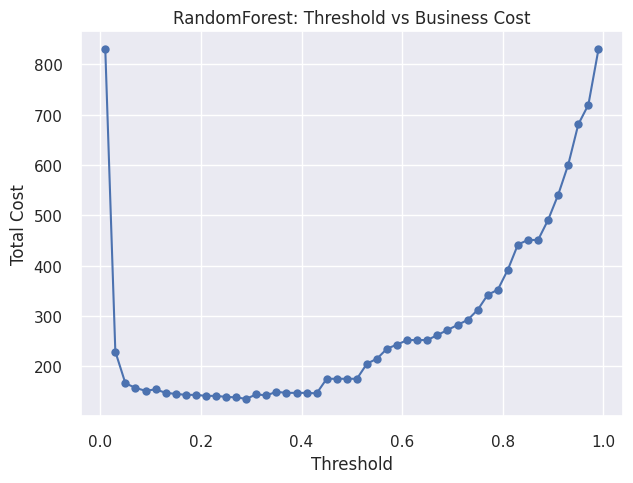

In [11]:
plt.figure(figsize=(7, 5))
plt.plot(rf_sweep_df["threshold"], rf_sweep_df["total_cost"], marker="o")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("RandomForest: Threshold vs Business Cost")
plt.grid(True)
plt.show()

In [12]:
# checking where cost is minimal,
rf_sweep_df.sort_values("total_cost").head(10)

,tn,fp,fn,tp,total_cost,fn_cost,fp_cost,threshold
14,56849,15,12,86,135.0,10.0,1.0,0.29
13,56846,18,12,86,138.0,10.0,1.0,0.27
12,56845,19,12,86,139.0,10.0,1.0,0.25
11,56843,21,12,86,141.0,10.0,1.0,0.23
10,56843,21,12,86,141.0,10.0,1.0,0.21
16,56852,12,13,85,142.0,10.0,1.0,0.33
8,56841,23,12,86,143.0,10.0,1.0,0.17
9,56841,23,12,86,143.0,10.0,1.0,0.19
15,56850,14,13,85,144.0,10.0,1.0,0.31
7,56839,25,12,86,145.0,10.0,1.0,0.15


In [13]:
# add class weighted baselines
# Logistic Regression with class_weight="balanced"
log_reg_bal = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced"))
])

log_reg_bal.fit(X_train, y_train)

# PROBAS:
y_proba_lr_bal = log_reg_bal.predict_proba(X_test)[:, 1]
# LABELS (using 0.5 threshold):
y_pred_lr_bal = (y_proba_lr_bal >= 0.5).astype(int)

results.append(
    evaluate_model("LogReg (class_weight=balanced)", y_test, y_pred_lr_bal, y_proba_lr_bal)
)

cost_lr_bal = compute_cost(y_test, y_pred_lr_bal, fn_cost=10.0, fp_cost=1.0)
cost_lr_bal["model"] = "LogReg (class_weight=balanced)"
business_df = pd.concat([business_df, pd.DataFrame([cost_lr_bal])], ignore_index=True)

business_df


=== LogReg (class_weight=balanced) ===
Accuracy:  0.9755
Precision: 0.0610
Recall:    0.9184
F1-score:  0.1144
ROC-AUC:   0.9721
PR-AUC:    0.7190

Confusion Matrix:
[[55478  1386]
 [    8    90]]




,model,tn,fp,fn,tp,fn_cost,fp_cost,total_cost
0,Majority Baseline,56864,0,98,0,10.0,1.0,980.0
1,Logistic Regression,56851,13,36,62,10.0,1.0,373.0
2,Random Forest,56859,5,17,81,10.0,1.0,175.0
3,LogReg (class_weight=balanced),55478,1386,8,90,10.0,1.0,1466.0


In [14]:
# random forest with class weigth balanced
rf_bal = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_bal.fit(X_train, y_train)

y_proba_rf_bal = rf_bal.predict_proba(X_test)[:, 1]
y_pred_rf_bal = (y_proba_rf_bal >= 0.5).astype(int)

results.append(
    evaluate_model("RF (class_weight=balanced)", y_test, y_pred_rf_bal, y_proba_rf_bal)
)

cost_rf_bal = compute_cost(y_test, y_pred_rf_bal, fn_cost=10.0, fp_cost=1.0)
cost_rf_bal["model"] = "RF (class_weight=balanced)"
business_df = pd.concat([business_df, pd.DataFrame([cost_rf_bal])], ignore_index=True)

business_df


=== RF (class_weight=balanced) ===
Accuracy:  0.9995
Precision: 0.9610
Recall:    0.7551
F1-score:  0.8457
ROC-AUC:   0.9572
PR-AUC:    0.8589

Confusion Matrix:
[[56861     3]
 [   24    74]]




,model,tn,fp,fn,tp,fn_cost,fp_cost,total_cost
0,Majority Baseline,56864,0,98,0,10.0,1.0,980.0
1,Logistic Regression,56851,13,36,62,10.0,1.0,373.0
2,Random Forest,56859,5,17,81,10.0,1.0,175.0
3,LogReg (class_weight=balanced),55478,1386,8,90,10.0,1.0,1466.0
4,RF (class_weight=balanced),56861,3,24,74,10.0,1.0,243.0


In [15]:
# Cost aware class_weight (using FN/FP ratio)
"""Right now our cost_obj is: FN cost = 10, FP cost = 1.
class_weight="balanced" ignores that, so we do a manual class weight roughly aligned with cost

Idea: give positive class a weight proportional to FN cost:"""

pos_weight = 10.0  # from fn_cost
neg_weight = 1.0   # from fp_cost

custom_class_weight = {0: neg_weight, 1: pos_weight}
custom_class_weight

{0: 1.0, 1: 10.0}

In [16]:
# Logistic Regression with cost-based weights
log_reg_cost = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        class_weight=custom_class_weight
    ))
])

log_reg_cost.fit(X_train, y_train)

y_proba_lr_cost = log_reg_cost.predict_proba(X_test)[:, 1]
y_pred_lr_cost = (y_proba_lr_cost >= 0.5).astype(int)

results.append(
    evaluate_model("LogReg (cost-based weights)", y_test, y_pred_lr_cost, y_proba_lr_cost)
)

cost_lr_cost = compute_cost(y_test, y_pred_lr_cost, fn_cost=10.0, fp_cost=1.0)
cost_lr_cost["model"] = "LogReg (cost-based weights)"
business_df = pd.concat([business_df, pd.DataFrame([cost_lr_cost])], ignore_index=True)

business_df


=== LogReg (cost-based weights) ===
Accuracy:  0.9991
Precision: 0.6917
Recall:    0.8469
F1-score:  0.7615
ROC-AUC:   0.9676
PR-AUC:    0.7485

Confusion Matrix:
[[56827    37]
 [   15    83]]




,model,tn,fp,fn,tp,fn_cost,fp_cost,total_cost
0,Majority Baseline,56864,0,98,0,10.0,1.0,980.0
1,Logistic Regression,56851,13,36,62,10.0,1.0,373.0
2,Random Forest,56859,5,17,81,10.0,1.0,175.0
3,LogReg (class_weight=balanced),55478,1386,8,90,10.0,1.0,1466.0
4,RF (class_weight=balanced),56861,3,24,74,10.0,1.0,243.0
5,LogReg (cost-based weights),56827,37,15,83,10.0,1.0,187.0


In [18]:
# Create oversampled RF baseline
ros = RandomOverSampler(random_state=42)

rf_over = ImbPipeline(steps=[
    ("oversample", ros),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf_over.fit(X_train, y_train)

y_proba_rf_over = rf_over.predict_proba(X_test)[:, 1]
y_pred_rf_over = (y_proba_rf_over >= 0.5).astype(int)

results.append(
    evaluate_model("RF (RandomOverSampler)", y_test, y_pred_rf_over, y_proba_rf_over)
)

cost_rf_over = compute_cost(y_test, y_pred_rf_over, fn_cost=10.0, fp_cost=1.0)
cost_rf_over["model"] = "RF (RandomOverSampler)"
business_df = pd.concat([business_df, pd.DataFrame([cost_rf_over])], ignore_index=True)

business_df


=== RF (RandomOverSampler) ===
Accuracy:  0.9996
Precision: 0.9506
Recall:    0.7857
F1-score:  0.8603
ROC-AUC:   0.9619
PR-AUC:    0.8670

Confusion Matrix:
[[56860     4]
 [   21    77]]




,model,tn,fp,fn,tp,fn_cost,fp_cost,total_cost
0,Majority Baseline,56864,0,98,0,10.0,1.0,980.0
1,Logistic Regression,56851,13,36,62,10.0,1.0,373.0
2,Random Forest,56859,5,17,81,10.0,1.0,175.0
3,LogReg (class_weight=balanced),55478,1386,8,90,10.0,1.0,1466.0
4,RF (class_weight=balanced),56861,3,24,74,10.0,1.0,243.0
5,LogReg (cost-based weights),56827,37,15,83,10.0,1.0,187.0
6,RF (RandomOverSampler),56860,4,21,77,10.0,1.0,214.0


In [21]:
metrics_df = pd.DataFrame(results)
print("=== Metrics ===")

display(metrics_df)

print("=== Business Cost ===")
display(business_df.sort_values("total_cost"))


=== Metrics ===


,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Majority Baseline,0.998280,0.000000,0.000000,0.000000,0.500000,0.001720
1,Logistic Regression,0.999140,0.826667,0.632653,0.716763,0.960549,0.741382
2,Random Forest,0.999614,0.941860,0.826531,0.880435,0.962346,0.873043
3,LogReg (class_weight=balanced),0.975528,0.060976,0.918367,0.114358,0.972083,0.718971
4,RF (class_weight=balanced),0.999526,0.961039,0.755102,0.845714,0.957189,0.858928
5,LogReg (cost-based weights),0.999087,0.691667,0.846939,0.761468,0.967590,0.748506
6,RF (RandomOverSampler),0.999561,0.950617,0.785714,0.860335,0.961934,0.866991


=== Business Cost ===


,model,tn,fp,fn,tp,fn_cost,fp_cost,total_cost
2,Random Forest,56859,5,17,81,10.0,1.0,175.0
5,LogReg (cost-based weights),56827,37,15,83,10.0,1.0,187.0
6,RF (RandomOverSampler),56860,4,21,77,10.0,1.0,214.0
4,RF (class_weight=balanced),56861,3,24,74,10.0,1.0,243.0
1,Logistic Regression,56851,13,36,62,10.0,1.0,373.0
0,Majority Baseline,56864,0,98,0,10.0,1.0,980.0
3,LogReg (class_weight=balanced),55478,1386,8,90,10.0,1.0,1466.0
